In [68]:
!pip install catboost

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/101.7 MB 812.7 kB/s eta 0:02:06
   ---------------------------------------- 0.2/101.7 MB 1.5 MB/s eta 0:01:09
   ---------------------------------------- 0.4/101.7 MB 2.2 MB/s eta 0:00:47
   ---------------------------------------- 0.6/101.7 MB 3.0 MB/s eta 0:00:34
   ---------------------------------------- 0.9/101.7 MB 3.4 MB/s eta 0:00:30
    --------------------------------------- 1.6/101.7 MB 5.0 MB/s eta 0:00:21
   - -------------------------------------- 3.0/101.7 MB 8.7 MB/s eta 0:00:12
   -- ------------------------------------- 5.8/101.7 MB 14.2 MB/s eta 0:00:07
   --- ------------------------------------ 9.8/101.7 MB 21.7 MB/s eta 0:00:05
   ----- ---------------------------------- 14.0/101.7 MB 93.0 MB/s eta 0:00:01
   ------ --------------------------------- 15.3/101.7 MB 65.6 MB/s eta 

## Задачи

1) предобработки данных
2) бинарной классификации
3) проведения A/B-тестирования
4) кластеризации
5) построения модели склонности клиента к покупке

## Библиотеки

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import re
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

## Работа с БД

In [3]:
dbfile = "data/result_data/shop_database.db"
conn = sqlite3.connect(dbfile)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table Name : {cursor.fetchall()}")

Table Name : [('purchases',), ('personal_data_coeffs',), ('personal_data',)]


In [5]:
df_personal = pd.read_sql_query("select personal_data_coeffs.id as id, personal_coef, \
                        age, gender, education, city, country from personal_data_coeffs \
                        LEFT join personal_data \
                        on personal_data_coeffs.id=personal_data.id \
                        union \
                        select personal_data_coeffs.id as id, personal_coef, \
                        age, gender, education, city, country from personal_data \
                        LEFT join personal_data_coeffs \
                        on personal_data_coeffs.id=personal_data.id \
                        ", conn)

In [6]:
df_shop = pd.read_sql_query("select * from purchases", conn)

In [6]:
conn.close()

## Моделирование фичи "Пол"

### Подготовка к моделированию 

In [17]:
df_unknown_gender = pd.read_csv("data/result_data/personal_data.csv.gz", compression='gzip')
df_unknown_gender = df_unknown_gender.sort_values("id").reset_index().drop("index", axis=1)
df_unknown_gender["gender"] = None

In [19]:
df_personal_full = df_personal.loc[~df_personal.gender.isna()].reset_index().drop("index", axis=1)
df_personal_not_full = df_personal.loc[df_personal.gender.isna()].reset_index().drop("index", axis=1)
df_personal_not_full = df_personal_not_full.fillna(df_unknown_gender)

df_personal_ = pd.concat([df_personal_full, df_personal_not_full]).reset_index().drop("index", axis=1)

C:\Users\1\AppData\Local\Temp\ipykernel_22408\4076741188.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_personal_ = pd.concat([df_personal_full, df_personal_not_full]).reset_index().drop("index", axis=1)


In [20]:
df_personal_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104989 entries, 0 to 104988
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   personal_coef  104989 non-null  float64
 2   age            104989 non-null  float64
 3   gender         89241 non-null   float64
 4   education      104989 non-null  object 
 5   city           104989 non-null  float64
 6   country        104989 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ MB


In [21]:
df_personal_["education"] = df_personal_["education"].astype('category')
df_personal_["education"] = df_personal_.education.cat.rename_categories({'среднее': 0, 'высшее': 1}).astype(int)

In [22]:
df_personal_t = df_personal_.copy()

In [25]:
df_personal_['gender'].value_counts(dropna=False)

gender
1.0    51132
0.0    38109
NaN    15748
Name: count, dtype: int64

In [24]:
df_personal_test = df_personal_[df_personal_['gender'].isna()]
df_personal_train = df_personal_[~df_personal_['gender'].isna()]

In [26]:
y_train = df_personal_train['gender']
y_test  = df_personal_test['gender']

In [28]:
x_train = df_personal_train.drop(["gender", "personal_coef", "id"], axis=1)
x_test = df_personal_test.drop(["gender", "personal_coef", "id"], axis=1)

### Случайный лес

In [27]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [35]:
rfc = RandomForestClassifier()

In [ ]:
params = {'n_estimators' : [300, 500, 700],
          'max_depth': np.arange(10, 60, 4),
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2)}
rs = RandomizedSearchCV(rfc, params, cv=skf, scoring='f1', n_jobs=-1, error_score='raise') # для выбора параметров испольуем F-меру
rs.fit(x_train, y_train)
print('Скор наилучший: ', rs.best_score_)
print('Лучшие параметры: ', rs.best_params_)

### CatBoost

In [40]:
cbc = CatBoostClassifier()

In [42]:
params = {'n_estimators' : [300, 500, 700],
          'max_depth': np.arange(10, 12, 16),
          }
rs = RandomizedSearchCV(cbc, params, cv=skf, scoring='f1', n_jobs=-1, error_score='raise') # для выбора параметров испольуем F-меру
rs.fit(x_train, y_train)
print('Скор наилучший: ', rs.best_score_)
print('Лучшие параметры: ', rs.best_params_)

C:\Users\1\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Learning rate set to 0.132394
0:	learn: 0.6876338	total: 151ms	remaining: 1m 15s
1:	learn: 0.6833544	total: 165ms	remaining: 41s
2:	learn: 0.6803294	total: 172ms	remaining: 28.5s
3:	learn: 0.6780286	total: 179ms	remaining: 22.1s
4:	learn: 0.6762689	total: 188ms	remaining: 18.6s
5:	learn: 0.6747729	total: 226ms	remaining: 18.6s
6:	learn: 0.6736816	total: 237ms	remaining: 16.7s
7:	learn: 0.6727482	total: 277ms	remaining: 17s
8:	learn: 0.6719695	total: 316ms	remaining: 17.3s
9:	learn: 0.6714841	total: 337ms	remaining: 16.5s
10:	learn: 0.6710695	total: 347ms	remaining: 15.4s
11:	learn: 0.6707546	total: 367ms	remaining: 14.9s
12:	learn: 0.6706109	total: 373ms	remaining: 14s
13:	learn: 0.6703521	total: 411ms	remaining: 14.3s
14:	learn: 0.6701213	total: 432ms	remaining: 14s
15:	learn: 0.6698825	total: 472ms	remaining: 14.3s
16:	learn: 0.6697120	total: 494ms	remaining: 14s
17:	learn: 0.6695492	total: 535ms	remaining: 14.3s
18:	learn: 0.6694841	total: 544ms	remaining: 13.8s
19:	learn: 0.6693701

In [43]:
cbc.best_score_

{}

#### Градиентный бустинг

In [ ]:
gbc = GradientBoostingClassifier()


In [ ]:
params = {"loss":["log_loss", "exponential"],
          "learning_rate": [0.01,0.1,1,10,100],
          'max_depth': np.arange(2, 60, 4),
          'max_features': ['sqrt', 'log2', None],
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2),
          "max_features":["log2","sqrt"],
          "criterion": ["friedman_mse",  "squared_error"],
          "subsample":np.arange(0.1, 1, 0.1),
          "n_estimators":[100, 300, 500]}
rscv = RandomizedSearchCV(gbc, params, cv=skf, scoring='f1', n_jobs=-1, error_score='raise')
rscv.fit(x_train, y_train)
print('Скор наилучший: ', rscv.best_score_)
print('Лучшие параметры: ', rscv.best_params_)

### Модель

In [9]:
model = GradientBoostingClassifier(subsample= 0.1, n_estimators = 100, min_samples_split= 18, min_samples_leaf = 7, max_features = 'sqrt', 
                                   max_depth = 58, loss = 'log_loss', learning_rate = 0.01, criterion =  'friedman_mse')
model.fit(x_train, y_train)


NameError: name 'x_train' is not defined

In [ ]:
predicted_train_GBC = model.predict(x_train)
predicted_test_gBC = model.predict(x_test)


In [ ]:
df_personal_test['gender'] = predicted_test_gBC 

In [10]:
header = ["id","gender"]
df_personal_test.to_csv('test.csv',  columns = header, index=False)

NameError: name 'df_personal_test' is not defined

In [15]:
df_personal_ = pd.concat([df_personal_test, df_personal_train])

NameError: name 'df_personal_test' is not defined

In [35]:
df_personal_ = df_personal_[df_personal_.country == 32]

In [42]:
df_personal_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104437 entries, 89241 to 89240
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104437 non-null  int64  
 1   personal_coef  104437 non-null  float64
 2   age            104437 non-null  float64
 3   gender         104437 non-null  float64
 4   education      104437 non-null  int32  
 5   city           104437 non-null  float64
 6   country        104437 non-null  float64
dtypes: float64(5), int32(1), int64(1)
memory usage: 6.0 MB


## Работа с df_shop

In [31]:
df_shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           786260 non-null  int64  
 1   product      786260 non-null  object 
 2   colour       666736 non-null  object 
 3   cost         786260 non-null  int64  
 4   product_sex  471548 non-null  float64
 5   base_sale    786260 non-null  int64  
 6   dt           786260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 42.0+ MB


In [ ]:
df_shop.

In [47]:
def print_useful_rows_info(df): 
    
    print("Количество полностью заполненных объектов из всей выборки:", len(df.dropna()))
    print("Процент полностью заполненных объектов из всей выборки:", round(len(df.dropna()) / len(df) * 100, 2))


In [49]:
print_useful_rows_info(df_shop)

Количество полностью заполненных объектов из всей выборки: 394887
Процент полностью заполненных объектов из всей выборки: 50.22


In [50]:
missing_values = ((df_shop.isna().sum() / len(df_shop)) * 100).sort_values(ascending=False) # Получаем список пропущенных колонок
missing_values

product_sex    40.026454
colour         15.201587
id              0.000000
product         0.000000
cost            0.000000
base_sale       0.000000
dt              0.000000
dtype: float64

#### product

In [52]:
df_shop['product'] = df_shop['product'].str.lower() 

In [53]:
df_shop['product'] = df_shop['product'].str.split().str.get(0)

#### product_sex 

In [55]:
df_shop['product_sex'] = df_shop['product_sex'].fillna(2)

### colour

In [57]:
df_shop['colour'] = df_shop['colour'].fillna('other')

In [59]:
df_shop['product'] = df_shop['product'].apply(lambda x: " ".join(re.findall('[А-Яа-я]{3,20}', x)).lower())

In [60]:
df_shop['colour'] = df_shop['colour'].replace(['чёрный'], 'черный')
df_shop['colour'] = df_shop['colour'].replace(['зелёный'], 'зеленый')

In [61]:
df_shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           786260 non-null  int64  
 1   product      786260 non-null  object 
 2   colour       786260 non-null  object 
 3   cost         786260 non-null  int64  
 4   product_sex  786260 non-null  float64
 5   base_sale    786260 non-null  int64  
 6   dt           786260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 42.0+ MB


## Объединение df

In [65]:
df_all = df_personal_.merge(df_shop, how= "inner", on= 'id')

In [66]:
df_all =df_all[df_all.country == 32]

## А/В Тестирование

Выбираем три кретерия для A/B тестирования: 1) средняя выручка 2) средний чек 3) количество покупок.

1) Нулевая гипотеза: **Средняя выручка** клиента в тестовой и контрольной группе **не имеет** статистически значимой разницы.
2) Альтернативная гипотеза: **Средняя выручка** клиента в тестовой и контрольной группе **имеет** статистически значимимую разницу.

1) Нулевая гипотеза: **Средний чек** клиента в тестовой и контрольной группе **не имеет** статистически значимой разницы.
2) Альтернативная гипотеза: **Средний чек** клиента в тестовой и контрольной группе **имеет** статистически значимую разницу.

1) Нулевая гипотеза: **Количество купленных товаров** у клиента в тестовой и контрольной группе **не имеет** статистически значимой разницы.
2) Альтернативная гипотеза: **Количество купленных товаров** у клиента в тестовой и контрольной группе **имеет** статистически значимую разницы.

#### Загрузка данных A/В Теста

In [80]:
with open('data/result_data/ids_first_company_positive.txt') as f:
    positive = f.read()
elem_list = re.split(';|,| ', positive)
positive = []
for i in elem_list:
    if i.isdigit():
        positive.append(int(i))
with open('data/result_data/ids_first_company_negative.txt') as f:
    negative = f.read()
elem_list = re.split(';|,| ', negative)
negative = []
for i in elem_list:
    if i.isdigit():
        negative.append(int(i))

#### Формирование новых фичей для гипотез 

In [82]:
# Первая кампания проводилась в период с 5-го по 16-й день, ID участвовавших в ней пользователей содержатся в файле
df_data = df_all[(df_all['dt'] >= 5) & (df_all['dt'] < 17)]

#### Гипотеза 1

1) Нулевая гипотеза: **Средняя выручка** клиента в тестовой и контрольной группе **не имеет** статистически значимой разницы.
2) Альтернативная гипотеза: **Средняя выручка** клиента в тестовой и контрольной группе **имеет** статистически значимимую разницу.

In [88]:
# Выручка на одного клиента
df_hyp_1 = df_data.groupby('id', as_index=False).agg({'cost':'sum'})

In [91]:
# Тестовая группа
positive_g = df_hyp_1.loc[df_hyp_1['id'].isin(positive), :]

In [92]:
# Контррольная группа
negative_g = df_hyp_1.loc[df_hyp_1['id'].isin(negative), :]

In [93]:
# Проверяем распределение групп
print(stats.shapiro(positive_g['cost']))
print(stats.shapiro(negative_g['cost']))


ShapiroResult(statistic=0.5352928638458252, pvalue=0.0)
ShapiroResult(statistic=0.4731825590133667, pvalue=0.0)


##### Тест Манна-Уитни для проверки гипотезы

In [96]:
# Распределения независимы
# Тест шапиро больше показал P-value больше порога значимости в 5% делаем вывод что распределение не нармальное
man = stats.mannwhitneyu(positive_g['cost'], negative_g['cost'])
print(man)

MannwhitneyuResult(statistic=13468819.5, pvalue=1.5179477947167395e-39)


Тест показал **P-value меньше 5%**, значит можно сделать вывод что есть статистическая разница между группами. И мы принимаем **альтернативную гипотезу**

##### График распределений

In [99]:
test= np.std(positive_g['cost']) / np.sqrt(len(positive_g['cost']))
control = np.std(negative_g['cost']) / np.sqrt(len(negative_g['cost']))


In [146]:
positive_g['cost'].mean()

27823.02446741194

In [148]:
negative_g['cost'].mean()

22451.607803292012

C:\Users\1\AppData\Local\Temp\ipykernel_25116\90306236.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_g['cost'].mean(),


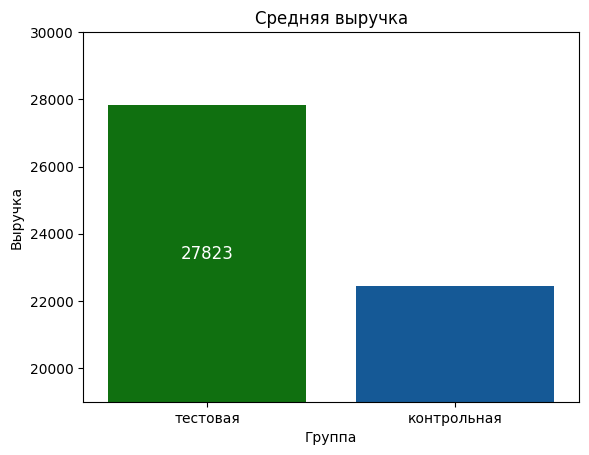

In [100]:
fig,ax = plt.subplots()
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_g['cost'].mean(),
                                                  negative_g['cost'].mean()],
                                                  palette=['Green','#005AAB'])
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.0f')
ax.set_title('Средняя выручка')
ax.set(xlabel='Группа', ylabel='Выручка',  ylim=(19000, 30000));



### 2 Гипотеза

1) Нулевая гипотеза: **Средний чек** клиента в тестовой и контрольной группе **не имеет** статистически значимой разницы.
2) Альтернативная гипотеза: **Средний чек** клиента в тестовой и контрольной группе **имеет** статистически значимую разницу.

In [109]:
# Средний чек 
df_hyp_2 = df_data.groupby(['id', 'dt'], as_index=False).agg({'cost':'sum'})

In [110]:
# Тестовая группа
positive_g_2 = df_hyp_2.loc[df_hyp_2['id'].isin(positive), :]

In [112]:
# Контррольная группа
negative_g_2 = df_hyp_2.loc[df_hyp_2['id'].isin(negative), :]

In [114]:
# Проверяем распределение групп
print(stats.shapiro(positive_g_2['cost']))
print(stats.shapiro(negative_g_2['cost']))

ShapiroResult(statistic=0.5642776489257812, pvalue=0.0)
ShapiroResult(statistic=0.5190801620483398, pvalue=0.0)


C:\Users\1\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


##### Тест Манна-Уитни для проверки гипотезы

In [118]:
# Распределения независимы
# Тест шапиро больше показал P-value больше порога значимости в 5% делаем вывод что распределение не нармальное
man = stats.mannwhitneyu(positive_g_2['cost'], negative_g_2['cost'])
print(man)

MannwhitneyuResult(statistic=71743457.0, pvalue=2.4484687354758497e-10)


Тест показал **P-value меньше 5%**, значит можно сделать вывод что есть статистическая разница между группами. И мы принимаем **альтернативную гипотезу**

##### График распределений

In [122]:
test_2= np.std(positive_g_2['cost']) / np.sqrt(len(positive_g_2['cost']))
control_2 = np.std(negative_g_2['cost']) / np.sqrt(len(negative_g_2['cost']))

In [152]:
positive_g_2['cost'].mean()

10580.649635036496

In [154]:
negative_g_2['cost'].mean()

10058.663692643846

C:\Users\1\AppData\Local\Temp\ipykernel_25116\2003382618.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_g_2['cost'].mean(),


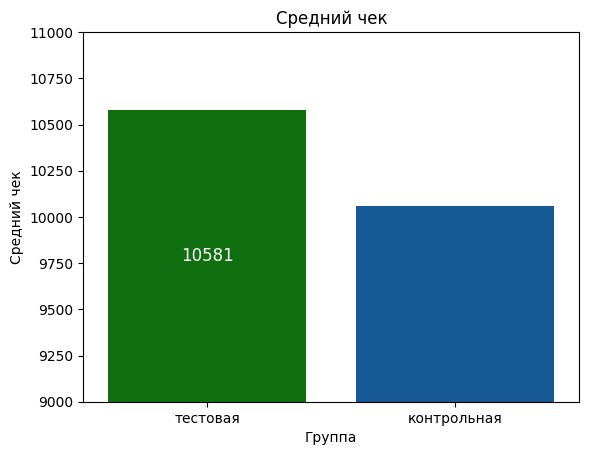

In [123]:
fig,ax = plt.subplots()
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_g_2['cost'].mean(),
                                                  negative_g_2['cost'].mean()],
                                                  palette=['green','#005AAB'])
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.0f')
ax.set_title('Cредний чек')
ax.set(xlabel='Группа', ylabel='Средний чек', ylim=(9000, 11000));


### 3 Гипотеза

1) Нулевая гипотеза: **Количество купленных товаров** у клиента в тестовой и контрольной группе **не имеет** статистически значимой разницы.
2) Альтернативная гипотеза: **Количество купленных товаров** у клиента в тестовой и контрольной группе **имеет** статистически значимую разницы.

In [127]:
# Количество купленых товаров
df_hyp_3 = df_data.groupby('id', as_index=False).agg({'cost':'count'})

In [128]:
# Контррольная группа
negative_g_3 = df_hyp_3.loc[df_hyp_3['id'].isin(negative), :]

In [132]:
# Тестовая группа
positive_g_3 = df_hyp_3.loc[df_hyp_3['id'].isin(positive), :]

In [134]:
# Проверяем распределение групп
print(stats.shapiro(positive_g_3['cost']))
print(stats.shapiro(negative_g_3['cost']))

ShapiroResult(statistic=0.7064881920814514, pvalue=0.0)
ShapiroResult(statistic=0.5769106149673462, pvalue=0.0)


In [135]:
# Распределения независимы
# Тест шапиро больше показал P-value больше порога значимости в 5% делаем вывод что распределение не нармальное
man = stats.mannwhitneyu(positive_g_3['cost'], negative_g_3['cost'])
print(man)

MannwhitneyuResult(statistic=14333830.0, pvalue=2.3754740763929797e-86)


Тест показал **P-value меньше 5%**, значит можно сделать вывод что есть статистическая разница между группами. И мы принимаем **альтернативную гипотезу**

In [139]:
test_3= np.std(positive_g_3['cost']) / np.sqrt(len(positive_g_3['cost']))
control_3 = np.std(negative_g_3['cost']) / np.sqrt(len(negative_g_3['cost']))

In [156]:
positive_g_3['cost'].mean()

5.2353933769247

In [160]:
negative_g_3['cost'].mean()

4.019711440764072

C:\Users\1\AppData\Local\Temp\ipykernel_25116\2890812275.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_g_3['cost'].mean(),


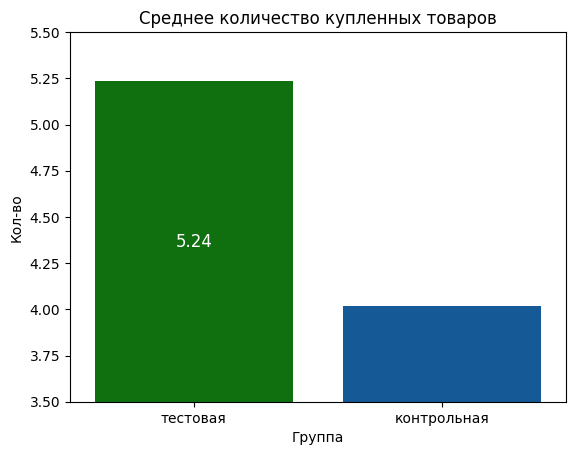

In [140]:
fig,ax = plt.subplots()
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_g_3['cost'].mean(),
                                                  negative_g_3['cost'].mean()],
                                                  palette=['Green','#005AAB'])
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.2f')
ax.set_title('Cреднее количество купленных товаров')
ax.set(xlabel='Группа', ylabel='Кол-во', ylim=(3.5, 5.5));



### Вывод

* По результатам А/В тестирования была выявлена значимая разница в 3 показателях: **Количество купленных товаров**; **Средний чек**; **Средняя выручка**. 
* Все показатели в тестовых группах значительно выше чем в контрольных группах: Количество купленных товаров - **31%**; Средний чек - **6%**; Средняя выручка - **25%**

Из этих данных можно сделать вывод что рекламная компания проходит успешно. рекомендация продолжать маркетинговую компанию

## Кластеризация

#### Создание DF для проверки

In [56]:
df_shop = df_shop[(df_shop['dt'] >= 5) & (df_shop['dt'] < 17)]

In [ ]:
purchases_summary = df_shop.groupby('id').agg({
    'product': 'count',
    'cost': 'sum',
    'base_sale': 'sum'
}).reset_index()

In [62]:
purchases_summary.columns = ['id', 'product_count', 'total_cost', 'total_base_sale']

In [68]:
merged_data = pd.merge(left=df_personal_, right=purchases_summary, on='id', how='inner')

In [70]:
merged_data['income_per_customer'] = merged_data['total_cost'] / merged_data['product_count']
merged_data['total_discount'] = merged_data['total_base_sale'] + merged_data['personal_coef']
merged_data['base_sale_ratio'] = merged_data['total_base_sale'] / merged_data['total_cost']

In [76]:
df_cluster = merged_data.drop(columns=['id','country'], axis=1)

In [80]:
df_cluster.columns

Index(['personal_coef', 'age', 'gender', 'education', 'city', 'product_count',
       'total_cost', 'total_base_sale', 'income_per_customer',
       'total_discount', 'base_sale_ratio'],
      dtype='object')

In [82]:
# стандартизации значений 
num_columns = ['personal_coef', 'age', 'gender', 'education', 'city', 'product_count',
       'total_cost', 'total_base_sale', 'income_per_customer',
       'total_discount', 'base_sale_ratio']
scaler = StandardScaler()
df_cluster[num_columns] = scaler.fit_transform(df_cluster[num_columns])

#### Визуализация 

C:\Users\1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: F

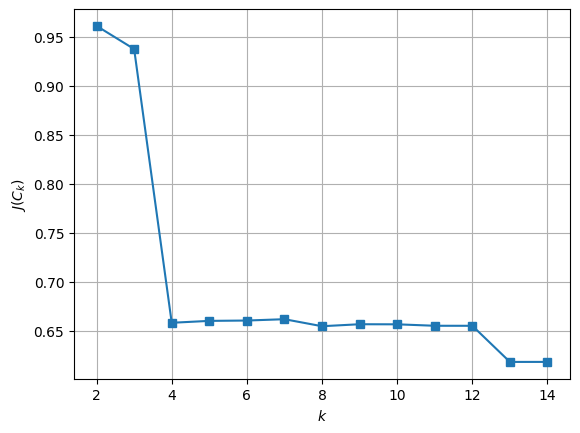

In [68]:
inertia = []
silhouette = []
N = 15
for k in range(2, N):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_cluster)
    preds = kmeans.predict(df_cluster)
    inertia.append(np.sqrt(kmeans.inertia_))
    silhouette.append(silhouette_score(df_cluster, preds))
plt.plot(range(2, N), silhouette, marker='s');
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');


In [84]:
kproto = KPrototypes(n_clusters=4, init='Cao', n_jobs=-1)
kproto.fit_predict(df_cluster, categorical=[0,2,3,4,5,6])

array([3, 1, 2, ..., 1, 3, 1], dtype=uint16)

In [85]:
# признаки преобразуем для визуализации
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
df_emb = tsne.fit_transform(df_cluster[num_columns])
data = pd.DataFrame(df_emb)

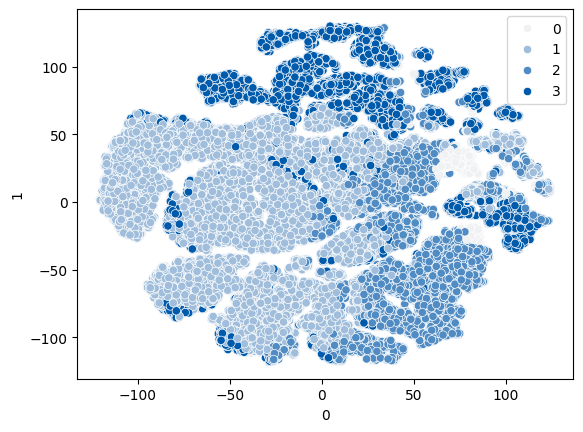

In [86]:
pallete = sns.color_palette("light:#005AAB", as_cmap=True)
sns.scatterplot(x=data[0], y=data[1], hue=kproto.labels_, palette=pallete);

#### Проверка кластеров

In [90]:
df_cluster[num_columns] = scaler.inverse_transform(df_cluster[num_columns])
num_columns.extend(['education','gender'])
mode_cols = set(df_cluster.columns) - set(num_columns)
d1 = dict.fromkeys(num_columns, 'mean')
d2 = dict.fromkeys(mode_cols, pd.Series.mode)


In [104]:
d = {**d1, **d2}
df_g1 = df_cluster.groupby(kproto.labels_, as_index=False).agg(d)
df_g1 = df_g1.round(2).T
df_g1 = df_g1.rename(columns={0:'cluster 1', 1:'cluster 2', 2:'cluster 3', 3:'cluster 4'})
df_g1

C:\Users\1\AppData\Local\Temp\ipykernel_7256\796645540.py:2: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  df_g1 = df_cluster.groupby(kproto.labels_, as_index=False).agg(d)


,cluster 1,cluster 2,cluster 3,cluster 4
personal_coef,0.47,0.46,0.49,0.43
age,39.65,43.45,40.64,22.10
gender,0.51,0.70,0.36,0.74
education,0.16,0.04,0.09,0.79
city,1126.30,1139.21,1136.69,1137.67
product_count,47.42,5.51,10.12,5.88
total_cost,215825.89,38165.03,35107.03,36310.56
total_base_sale,24.08,1.18,5.13,1.72
income_per_customer,4064.37,7107.68,2943.53,6237.08
total_discount,24.55,1.64,5.62,2.15


#### Выводы:

База клиентов разбилась на 4 кластера:

* Кластер № 1 включает в себя: Возрастную группу клиентов средний возраст которых 39 лет, по гендору разделение практически 50/50 % и 16 % из них имеют высшее образование. В группе наблюдается самый большой интерес к уникальным product 47, потратила группа (215 825), одина едица товара в среднем стоила 4064, общаяя скидка была 24.

* Кластер № 2 включает в себя: Возрастную группу клиентов средний возраст которых 43 года, по гендору разделение в сторону женского пола 70%. Потратила группа (38165),самая дорогая едица товара из всех групп, в среднем стоила 7107.

* Кластер № 3 включает в себя: Возрастную группу клиентов средний возраст которых 41 год, по гендору разделение в сторону мужского пола 36%. Самая сбалансированая группа по моему мнению в плане покупок. В среднем 10 уникальных товаров, потратили (35107), средняя стоимость товаров 2943.

* Кластер № 4 включает в себя: Самоя молодая возрастная группа клиентов, средний возраст которых 22 года,по гендору разделение в сторону женского пола 74% и самая образованая 79 % из них имеют высшее образование. В среднем 5 уникальных товаров, потратили (36310), средняя стоимость товаров 6237.


## Модель предсказания повышения спроса после второй рекламной кампании

### Подготовка модели

In [62]:
# Загружаем еще раз данные по рекламной компании 
with open('data/result_data/ids_first_company_positive.txt') as f:
    positive = f.read()
elem_list = re.split(';|,| ', positive)
positive = []
for i in elem_list:
    if i.isdigit():
        positive.append(int(i))

In [64]:
# Покупки клиентов первой компании 
df_first = df_shop[(df_shop['dt'] >= 5) & (df_shop['dt'] < 17)]
product_group = df_first.groupby('id', as_index=False).agg({'product': pd.Series.mode})
first_camp = product_group.loc[product_group['id'].isin(positive), :]
first_camp['product'] = first_camp['product'].apply(lambda x: x[0] if type(x) == np.ndarray else x)

C:\Users\1\AppData\Local\Temp\ipykernel_7304\1472883761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_camp['product'] = first_camp['product'].apply(lambda x: x[0] if type(x) == np.ndarray else x)


In [65]:
# Покупки клиентов  2 компании
df_second = df_shop[(df_shop['dt'] == 15) | (df_shop['dt'] == 45)]
second_camp = df_second.groupby('id', as_index=False).agg({'product': pd.Series.mode})
second_camp['product'] = second_camp['product'].apply(lambda x: x[0] if type(x) == np.ndarray else x)

In [66]:
# Объединяем с базу клиентов и покупки
first_df = pd.merge(left =df_personal_,right = df_first, on = 'id' ,how = 'inner')
second_df = pd.merge(left =df_personal_,right = df_second, on = 'id' ,how = 'inner')

In [67]:
second_df = second_df[second_df.city == 1134]

In [68]:
# train 
train = first_df.merge(second_df)

In [124]:
# Проверка на дубли
train.drop_duplicates()

,id,personal_coef,age,gender,education,city,country,product,colour,cost,product_sex,base_sale,dt
0,365,0.4304,29.0,1.0,0,1134.0,32.0,рюкзак,черный,38199,2.0,0,15
1,365,0.4304,29.0,1.0,0,1134.0,32.0,станок,other,21999,2.0,0,15
2,383,0.4304,45.0,1.0,0,1134.0,32.0,рюкзак,серый/зеленый,1599,2.0,0,15
3,665,0.5072,65.0,1.0,0,1134.0,32.0,брюки,other,1999,1.0,0,15
4,1462,0.5584,26.0,1.0,1,1134.0,32.0,мешок,Синий,14599,2.0,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7164,177889,0.4304,44.0,1.0,0,1134.0,32.0,кроссовки,other,9299,2.0,0,15
7165,177889,0.4304,44.0,1.0,0,1134.0,32.0,полуботинки,other,7599,1.0,0,15
7166,177966,0.2672,17.0,1.0,1,1134.0,32.0,перчатки,желтый/черный,2599,2.0,0,15
7167,177982,0.4304,38.0,1.0,0,1134.0,32.0,бейсболка,черный,1999,2.0,0,15


In [69]:
# Упрощаем название товаров
train['product'] = train['product'].apply(lambda x: x.split(' ')[0])

In [138]:
test = df_all[(df_all.city == 1188) & (df_all.country == 32)]

In [156]:
x_train = train.drop(columns=['id', 'product','colour'])
y_train = train['product']
x_test = test.drop(columns=['id', 'product','colour'])

In [144]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rfc = RandomForestClassifier()

In [146]:
# Ищем лучшие параметры для модели 
params = {'n_estimators' : [300, 500, 700],
          'max_depth': np.arange(10, 60, 4),
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2),
          'class_weight': ('balanced', None)}
rs = RandomizedSearchCV(rfc, params, cv=skf, scoring='f1_micro', n_jobs=-1, error_score='raise') # по F-мере
rs.fit(x_train, y_train)
print('Лучший скор: ', rs.best_score_)
print('Лучшие параметры: ', rs.best_params_)

C:\Users\1\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Лучший скор:  0.22778728400099713
Лучшие параметры:  {'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_depth': 58, 'class_weight': None}


In [152]:
model = RandomForestClassifier(n_estimators=300, min_samples_split=6, min_samples_leaf=6, max_depth=58, class_weight=None)
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=58, min_samples_leaf=6, min_samples_split=6,
                       n_estimators=300)

In [160]:
# Выведем результат нашей модели 
model_pred = model.predict(x_test)
x_test['product'] = model_pred
x_test['product'].value_counts()


product
кроссовки    32224
футболка     10050
брюки         9361
шорты         4304
велосипед     3567
             ...  
образный         1
диск             1
батончик         1
палки            1
чайник           1
Name: count, Length: 118, dtype: int64